## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'
df = pd.read_csv(data)
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [7]:
cat_cols = list(df.dtypes[df.dtypes == 'O'].index)

num_cols = list(set(df.columns) - set(cat_cols))

print('Categorical Columns:', ', '.join(cat_cols))
print('Numerical Columns:', ', '.join(num_cols))

Categorical Columns: home, marital, records, job
Numerical Columns: default, expenses, assets, price, income, debt, amount, age, time, seniority


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [8]:
X = df.drop('default', axis=1)
y = df.default

X_f, X_test, y_f, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(X_f, y_f, test_size=0.25, random_state=1)

In [9]:
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((2672, 13), (2672,)), ((891, 13), (891,)), ((891, 13), (891,)))

In [10]:
display(x_train.head())
print(y_train.head())

display(x_val.head())
print(y_val.head())

display(X_test.head())
print(y_test.head())

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
1877,12,private,24,28,married,no,fixed,45,102,0,0,700,1229
1803,4,other,60,28,married,no,fixed,60,143,0,0,1150,1630
3400,0,owner,60,27,married,no,fixed,35,295,6000,0,1950,2208
3529,6,owner,48,28,married,no,fixed,45,114,3500,0,650,1255
1721,12,owner,36,42,married,no,freelance,60,0,15000,0,1000,1500


1877    1
1803    0
3400    0
3529    0
1721    0
Name: default, dtype: int32


,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
3346,15,owner,48,37,married,yes,freelance,45,178,30000,9500,2400,3120
2984,2,owner,48,57,married,no,fixed,45,184,4000,0,1000,1500
322,1,parents,60,23,single,no,fixed,35,90,0,0,1100,1107
11,7,owner,36,29,married,no,fixed,60,121,3000,0,650,915
1041,9,owner,60,47,married,no,freelance,75,178,50000,0,1850,1852


3346    0
2984    0
322     1
11      0
1041    0
Name: default, dtype: int32


,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
808,1,parents,24,19,single,no,fixed,35,28,0,0,400,600
1412,14,private,12,49,married,no,fixed,90,140,3000,500,400,1432
1179,5,other,48,22,single,no,fixed,35,82,0,0,480,1910
1669,2,parents,48,20,single,no,fixed,35,318,0,0,740,1325
2051,0,private,36,60,married,no,fixed,60,140,3000,0,1000,2050


808     0
1412    0
1179    1
1669    0
2051    0
Name: default, dtype: int32


In [11]:
num_cols = [col for col in num_cols if col != 'default']
num_cols

['expenses',
 'assets',
 'price',
 'income',
 'debt',
 'amount',
 'age',
 'time',
 'seniority']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [12]:
def tpr_fpr_dataframe(y_val,col, label=None):
    scores = []
    
    if label == -1:
        x = -x_train[col]
    else:
        x = x_train[col]
        
    for threshold in np.linspace(min(x),max(x),100):
        
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (x >= threshold)
        predict_negative = (x < threshold)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((threshold, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [13]:
score_auc = {'features': [], 'auc': []}
for col in num_cols:
        temp_df = tpr_fpr_dataframe(y_train, col)
        if auc(temp_df.fpr, temp_df.tpr) < 0.5:
            temp_df = tpr_fpr_dataframe(y_train, col, label=-1)
        score_auc['features'].append(col)
        score_auc['auc'].append(auc(temp_df.fpr, temp_df.tpr))
    
aucs = pd.DataFrame(score_auc)
display(aucs)

,features,auc
0,expenses,0.463745
1,assets,0.562632
2,price,0.504400
3,income,0.676871
4,debt,0.159950
5,amount,0.591277
6,age,0.573292
7,time,0.560866
8,seniority,0.701770


Which categorical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [14]:
print(aucs['features'][aucs.auc == aucs.auc.max()])

8    seniority
Name: features, dtype: object


## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [15]:
dv = DictVectorizer(sparse=False)

train_dict = x_train[cat_cols + num_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [16]:
val_dict = x_val[cat_cols + num_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict(X_val)
auc_val = roc_auc_score(y_val, y_pred)
print(round(auc_val, 3))

0.714


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

,Threshold,Precision,Recall
0,0.0,0.276094,1.000000
10,0.1,0.684492,0.520325
20,0.2,0.684492,0.520325
30,0.3,0.684492,0.520325
40,0.4,0.684492,0.520325
50,0.5,0.684492,0.520325
60,0.6,0.684492,0.520325
70,0.7,0.684492,0.520325
80,0.8,0.684492,0.520325
90,0.9,0.684492,0.520325


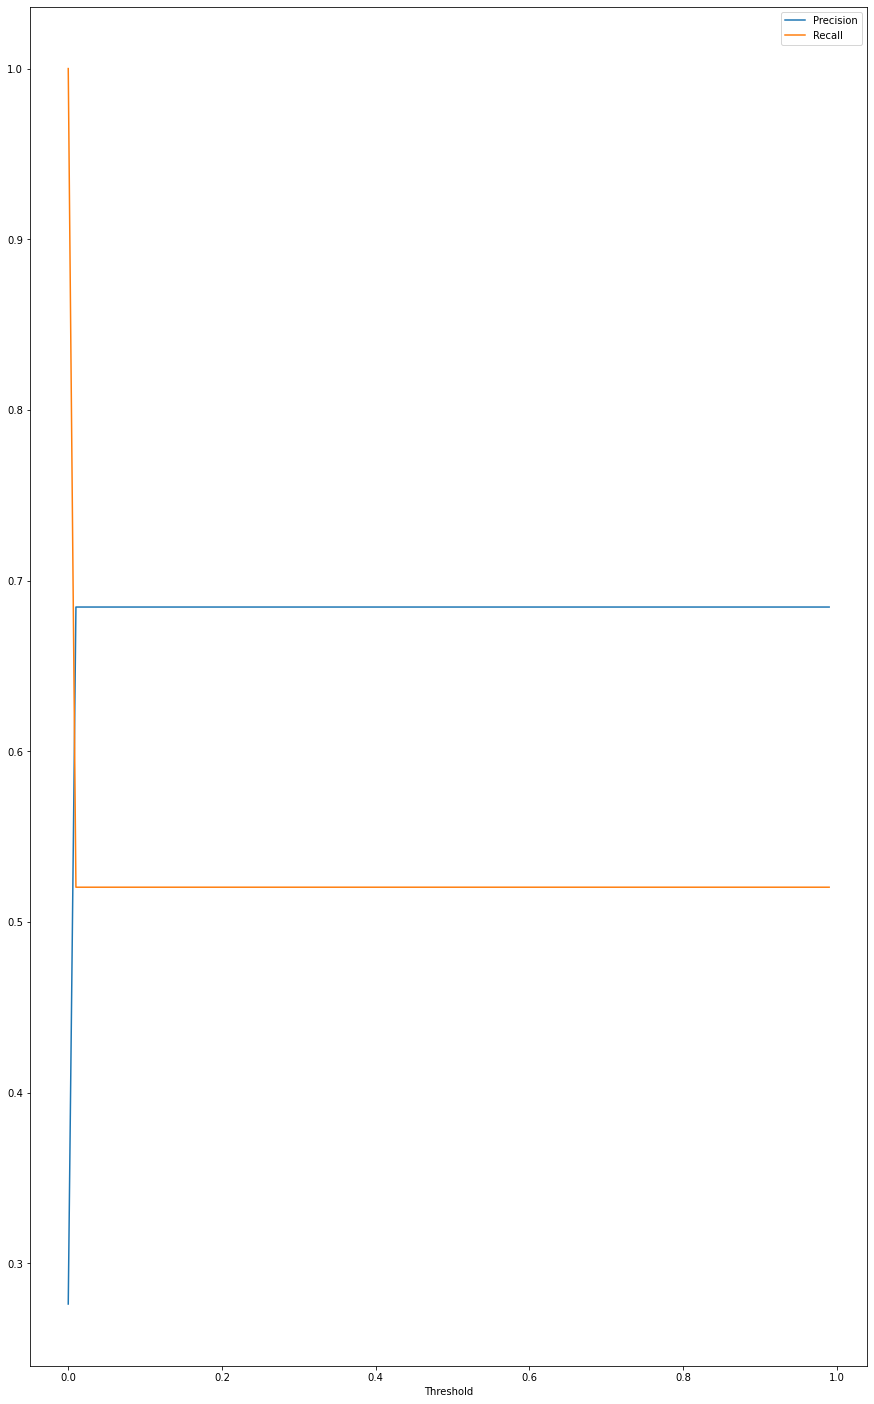

In [17]:
thresholds = np.arange(0, 1, .01)
pr =[]

for t in thresholds:
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum() 
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    pr.append((t, p, r))
    
pr_df = pd.DataFrame(pr, columns=['Threshold', 'Precision', 'Recall'])
display(pr_df[::10])
plt.figure(figsize=(15, 25))
plt.plot(pr_df.Threshold, pr_df.Precision, label = 'Precision')
plt.plot(pr_df.Threshold, pr_df.Recall, label = 'Recall')
plt.xlabel('Threshold')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

In [18]:
pr_df.Threshold[pr_df.Precision == pr_df.Recall]

Series([], Name: Threshold, dtype: float64)

## Quesiton 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [19]:
thresholds = np.arange(0, 1, .01)
prf =[]

for t in thresholds:
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum() 
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * (p * r) / (p + r)
    prf.append((t, p, r, f1))
    
prf_df = pd.DataFrame(prf, columns=['Threshold', 'Precision', 'Recall', 'F1 Score'])
display(prf_df[::10])

,Threshold,Precision,Recall,F1 Score
0,0.0,0.276094,1.000000,0.432718
10,0.1,0.684492,0.520325,0.591224
20,0.2,0.684492,0.520325,0.591224
30,0.3,0.684492,0.520325,0.591224
40,0.4,0.684492,0.520325,0.591224
50,0.5,0.684492,0.520325,0.591224
60,0.6,0.684492,0.520325,0.591224
70,0.7,0.684492,0.520325,0.591224
80,0.8,0.684492,0.520325,0.591224
90,0.9,0.684492,0.520325,0.591224


At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [20]:
prf_df.Threshold[prf_df['F1 Score'] == prf_df['F1 Score'].max()]

1     0.01
2     0.02
3     0.03
4     0.04
5     0.05
      ... 
95    0.95
96    0.96
97    0.97
98    0.98
99    0.99
Name: Threshold, Length: 99, dtype: float64

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [21]:
df

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,1,rent,60,39,married,no,fixed,69,92,0,0,900,1020,1
4450,22,owner,60,46,married,no,fixed,60,75,3000,600,950,1263,0
4451,0,owner,24,37,married,no,partime,60,90,3500,0,500,963,1
4452,0,rent,48,23,single,no,freelance,49,140,0,0,550,550,0


In [22]:
class LogReg_foldsCV:
    def __init__(self, df_full, C=1, splits=5):
        self.C = C
        self.n = splits
        self.df_full_train = df_full
        print('Object Initialized')
        
    def train(self, df_train, y_train, C=1.0):
        dicts = df_train[cat_cols + num_cols].to_dict(orient='records')

        self.dv = DictVectorizer(sparse=False)
        X_train = self.dv.fit_transform(dicts)

        self.model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        self.model.fit(X_train, y_train)

        return self.dv, self.model

    def predict(self, df):
        dicts = df[cat_cols + num_cols].to_dict(orient='records')

        X = self.dv.transform(dicts)
        y_pred = self.model.predict_proba(X)[:, 1]

        return y_pred

    def scoring(self, c=None):
        scores = []
        c = self.C if c == None else c
        
        kfold = KFold(n_splits=self.n, shuffle=True, random_state=1)

        for train_idx, val_idx in tqdm(kfold.split(self.df_full_train), total=5, desc='Scoring the Model'):

            df_train = self.df_full_train.iloc[train_idx]
            df_val = self.df_full_train.iloc[val_idx]

            y_train = df_train.default.values
            y_val = df_val.default.values

            self.train(df_train, y_train, C=c)
            y_pred = self.predict(df_val)

            auc = roc_auc_score(y_val, y_pred)
            print(auc)
            scores.append(auc)

        mu, s = np.mean(scores), np.std(scores)
        print(f'\nScore: {mu} +- {s}')
        return mu, s

    def CV(self, C):
        cv = []
        for c in tqdm(C, total=len(C), desc='Cross Validating'):
                mu, s = self.scoring(c=c)
                cv.append((c, mu, s))
        df_cv = pd.DataFrame(cv, columns=['C', 'Mean', '\u03C3'])
        return df_cv


In [23]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

score = LogReg_foldsCV(df_full_train)
mu, std = score.scoring()

Object Initialized


Scoring the Model:   0%|          | 0/5 [00:00<?, ?it/s]

0.8556875556875557
0.8660091770454681
0.8298724591470705
0.8553727940887474
0.803974988411802

Score: 0.8421833948761288 +- 0.02251857886217388


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [24]:
score = LogReg_foldsCV(df_full_train)
cv = score.CV([0.01, 0.1, 1, 10])
display(cv)

Object Initialized


Cross Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring the Model:   0%|          | 0/5 [00:00<?, ?it/s]

0.8417582417582418
0.851796674810798
0.8301115982463133
0.8472959163620641
0.7964734039030943

Score: 0.8334871670161021 +- 0.01987834719426708


Scoring the Model:   0%|          | 0/5 [00:00<?, ?it/s]

0.8554895554895554
0.8642115090479312
0.830789159027501
0.8515898282435248
0.8151280377633359

Score: 0.8434416179143698 +- 0.017914675804695097


Scoring the Model:   0%|          | 0/5 [00:00<?, ?it/s]

0.8556875556875557
0.8660091770454681
0.8298724591470705
0.8553727940887474
0.803974988411802

Score: 0.8421833948761288 +- 0.02251857886217388


Scoring the Model:   0%|          | 0/5 [00:00<?, ?it/s]

0.855034155034155
0.8618079971396222
0.8296831406935034
0.8538989112919075
0.8147591073776619

Score: 0.8430366623073701 +- 0.01784504384085696


,C,Mean,σ
0,0.01,0.833487,0.019878
1,0.10,0.843442,0.017915
2,1.00,0.842183,0.022519
3,10.00,0.843037,0.017845


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [25]:
cv.C[cv.Mean == cv.Mean.min()]

0    0.01
Name: C, dtype: float64

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.